<a href="https://colab.research.google.com/github/EzeRivero/DataScienceCoder/blob/main/ProyectoDSParteIIIRivero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1° Entrega Data Science I
##Ezequiel Rivero
*Comisión 84650*

En este trabajo estaré utilizando un dataset obtenido desde Kaggle.com, el cual trata de información sobre puestos de trabajo y salarios relacionados con Inteligencia Artificial, y tendencias en cuanto al mercado laboral global.

Elegí este dataset ya que es un tema en auge en la actualidad, y me pareció interesante analizarlo, además de que esta base de datos cumple con todos los requisitos de la entrega (tamaño, cantidad de variables, etc.). Es una temática que se encuentra en crecimiento y un mercado laboral de alta demanda, por lo que este análisis puede ser valioso. Cabe mencionar que los datos fueron generados artificialmente mediante herramientas de IA, por lo que no se tomaron fuentes de datos reales, aunque no impide su uso educacional y práctico.

El **objetivo** será ***analizar los factores que influyen sobre el salario anual***, tanto demográficos como laborales, y poder desarrollar un modelo predictivo de regresión para poder estimar el mismo. Es por ello que para orientarnos en la elaboración de las hipótesis, buscaremos responder las siguientes preguntas:
+ ¿Cómo varía el salario anual según el nivel de experiencia (Entry, Mid, Senior, Executive)?
+ ¿Hay diferencias significativas entre las distintos grados de presencialidad (Remoto, Híbrido, Presencial)?
+ ¿Hay países que tengan, en promedio, mejores salarios que otros?
+ ¿Cómo se relacionan las variables como experiencia, presencialidad y país simultaneamente, con el salario anual?
+ ¿Hay alguna/s otra/s variable/s que modifique/n el salario anual de manera relevante?

##Hipótesis:

Hipótesis Nula (H0): No existe una relación estadísticamente significativa entre alguna de las características laborales y el salario anual.

Hipótesis Alternativa (HA): Es posible construir un modelo de regresión (Random Forest Regressor) utilizando las características disponibles que prediga el salario promedio con un coeficiente de determinación (R²) significativamente superior a 0 (idealmente > 0.5 o 0.6 para considerarlo útil) y un Error Absoluto Medio (MAE) razonablemente bajo, a partir de las características laborales.

Hipótesis específicas:
* HA1: Los puestos para el nivel de experiencia Executive tienen un salario anual promedio mayor a los demás niveles.
* HA2: A mayor grado de presencialidad, mayor salario.
* HA3: Las ofertas laborales de países europeos superan en salario a países del continente asiático.

*Para comenzar con el análisis de los datos, importamos las librerías que utilizaremos, cargamos el dataset y observamos sus características generales:*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
url = 'https://raw.githubusercontent.com/EzeRivero/DataScienceCoder/refs/heads/main/ai_job_dataset.csv'

df = pd.read_csv(url)

In [3]:
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   job_id                  15000 non-null  object        
 1   job_title               15000 non-null  object        
 2   salary_usd              15000 non-null  int64         
 3   salary_currency         15000 non-null  object        
 4   experience_level        15000 non-null  object        
 5   employment_type         15000 non-null  object        
 6   company_location        15000 non-null  object        
 7   company_size            15000 non-null  object        
 8   employee_residence      15000 non-null  object        
 9   remote_ratio            15000 non-null  int64         
 10  required_skills         15000 non-null  object        
 11  education_required      15000 non-null  object        
 12  years_experience        15000 non-null  int64 

In [5]:
#Formateamos a formato datetime las columnas con fechas (para ver el cambio, ejecutamos nuevamente df.info)

df['application_deadline'] = pd.to_datetime(df['application_deadline'])
df['posting_date'] = pd.to_datetime(df['posting_date'])

In [6]:
df.dtypes['application_deadline']
df.dtypes['posting_date']

dtype('<M8[ns]')

In [8]:
#Datos estadísticos descriptivos de las variables numéricas
df.describe()

,salary_usd,remote_ratio,years_experience,posting_date,application_deadline,job_description_length,benefits_score
count,15000.000000,15000.000000,15000.000000,15000,15000,15000.000000,15000.000000
mean,115348.965133,49.483333,6.253200,2024-08-29 08:48:51.840000,2024-10-11 21:55:23.520000,1503.314733,7.504273
min,32519.000000,0.000000,0.000000,2024-01-01 00:00:00,2024-01-16 00:00:00,500.000000,5.000000
25%,70179.750000,0.000000,2.000000,2024-04-29 00:00:00,2024-06-13 00:00:00,1003.750000,6.200000
50%,99705.000000,50.000000,5.000000,2024-08-28 00:00:00,2024-10-12 00:00:00,1512.000000,7.500000
75%,146408.500000,100.000000,10.000000,2024-12-29 00:00:00,2025-02-10 00:00:00,2000.000000,8.800000
max,399095.000000,100.000000,19.000000,2025-04-30 00:00:00,2025-07-11 00:00:00,2499.000000,10.000000
std,60260.940438,40.812712,5.545768,NaN,NaN,576.127083,1.450870


In [9]:
#Nos aseguramos que no hay presencia de valores nulos
print(df.isnull().sum())

job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64


In [10]:
#Datos estadísticos descriptivos de las variables tipo object
df.describe(include=object)

,job_id,job_title,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,required_skills,education_required,industry,company_name
count,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
unique,15000,20,3,4,4,20,3,20,13663,4,15,16
top,AI15000,Machine Learning Researcher,USD,MI,FT,Germany,S,Sweden,"Python, TensorFlow, PyTorch",Bachelor,Retail,TechCorp Inc
freq,1,808,11957,3781,3812,814,5007,790,17,3789,1063,980


Luego de un pantallazo general, procederemos a llamar unos gráficos sobre las variables salary_usd, employment_type, experience_level y company_location.

Text(0, 0.5, 'Frecuencia')

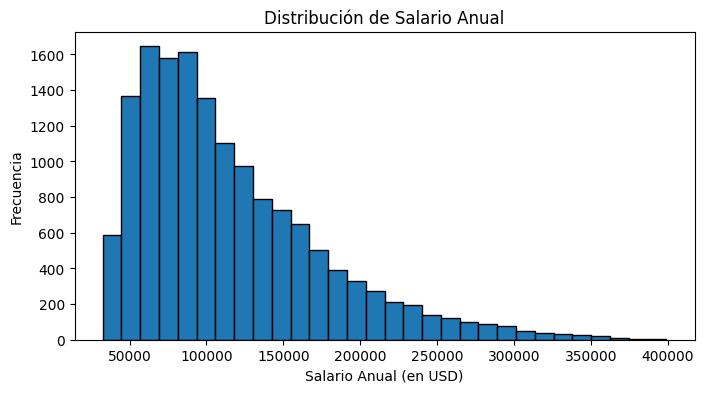

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['salary_usd'], bins=30, edgecolor='black')
ax.set_title('Distribución de Salario Anual')
ax.set_xlabel('Salario Anual (en USD)')
ax.set_ylabel('Frecuencia')

Como podemos ver, el salario anual tiene una distribución hacia valores más bajos (mediana de 99.705 dólares, y un promedio de 115.349 dólares). A continuación, trataremos de ver cuales factores afectan a dicha distribución.

Comenzando con niveles de experiencia, veremos un gráfico de violín desde Seaborn para observar cómo varía según cada categoría:


Text(0, 0.5, 'Nivel de Experiencia')

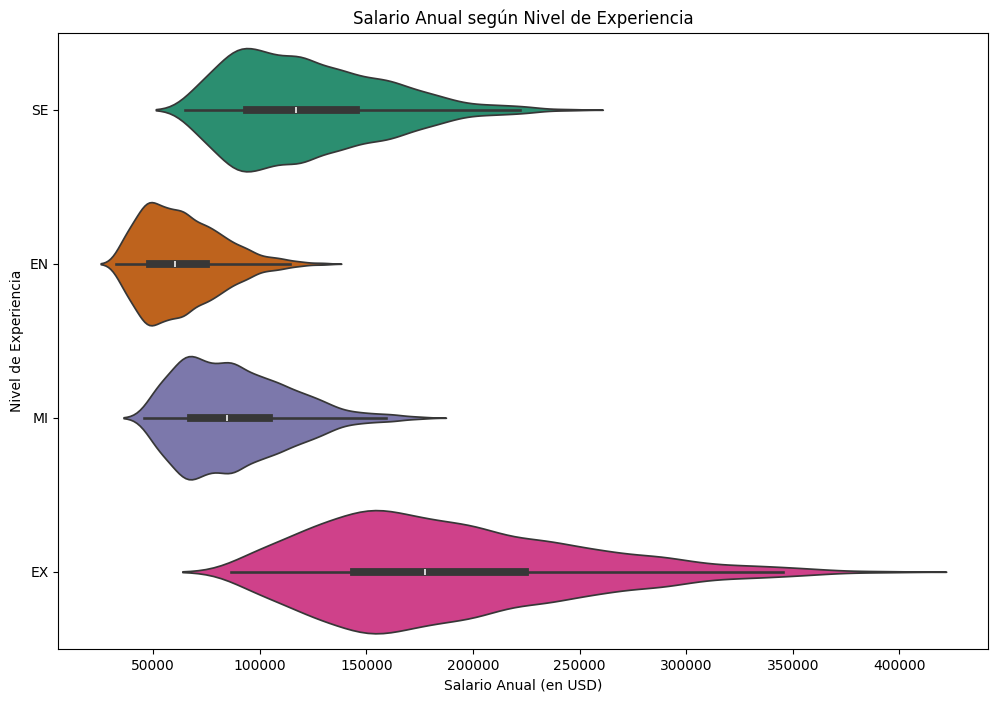

In [12]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='salary_usd', y='experience_level', hue='experience_level', inner='box', palette='Dark2')
plt.title('Salario Anual según Nivel de Experiencia')
plt.xlabel('Salario Anual (en USD)')
plt.ylabel('Nivel de Experiencia')

Acá podemos notar que se cumple la primera hipótesis alternativa, ya que a medida que avanza el nivel de experiencia requerido para el puesto (Entry->Mid->Senior->Executive), los salarios crecen.

Abajo continuamos con la segunda hipótesis alternativa, con respecto a Tipo de Empleo (Part Time, Full Time, Contrato o Freelance)

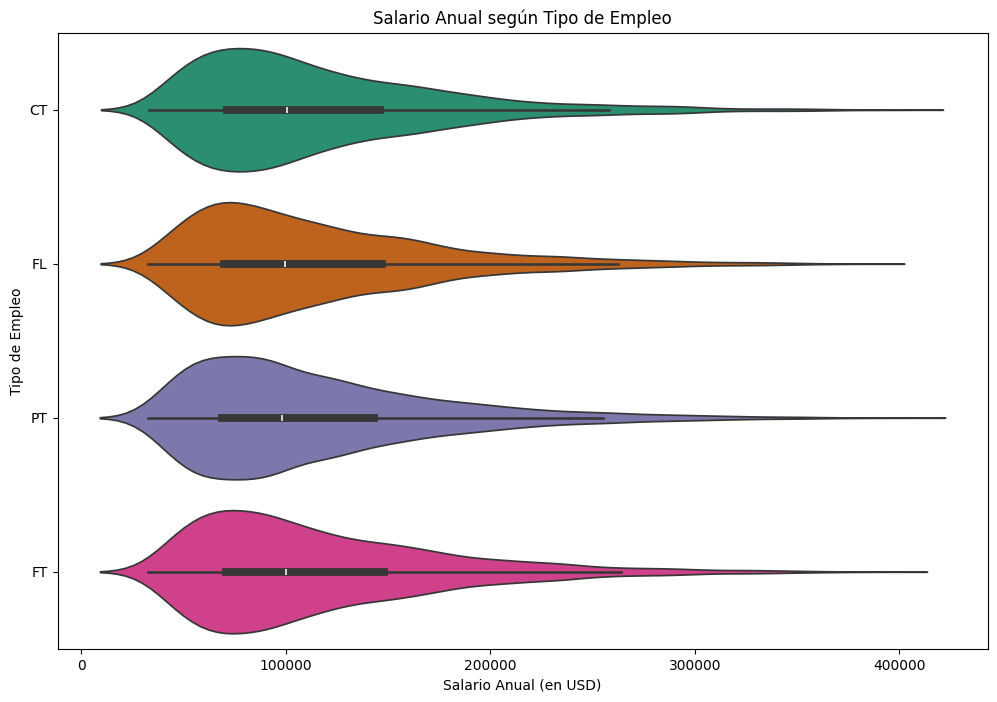

In [13]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='salary_usd', y='employment_type', hue='employment_type', inner='box', palette='Dark2')
plt.title('Salario Anual según Tipo de Empleo')
plt.xlabel('Salario Anual (en USD)')
plt.ylabel('Tipo de Empleo')
plt.show()

En este caso, queda descartada dicha hipótesis ya que apenas varían los salarios según estos parámetros.

Para la hipótesis restante, analizaremos la distribución del salario por países (donde cada empresa se ubica geográficamente).

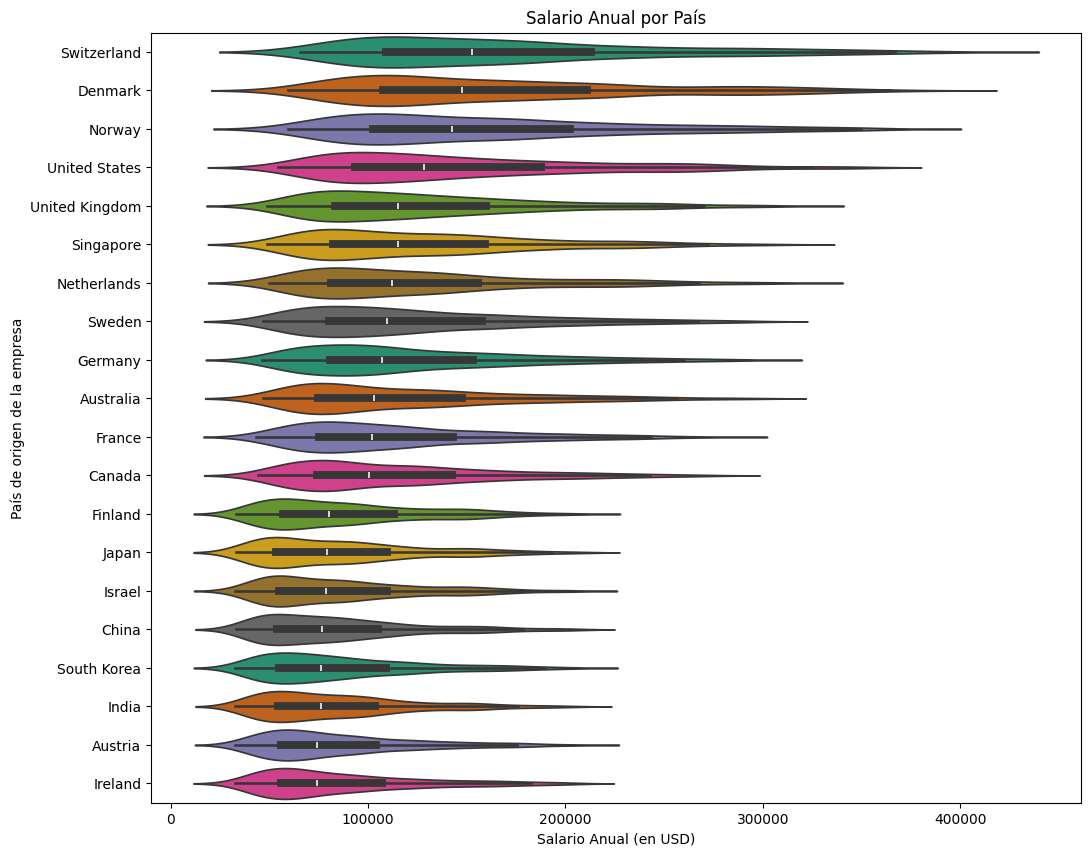

In [14]:
# Primeramente, para tener los países ordenados de mayor a menor, tomaremos la mediana como referencia
Salario_por_país_mediana = df.groupby('company_location')['salary_usd'].median().sort_values(ascending=False)

df['company_location'] = pd.Categorical(df['company_location'], categories=Salario_por_país_mediana.index, ordered=True)

# Finalmente creamos el gráfico de violín con los datos en orden descendente
plt.figure(figsize=(12, 10))
sns.violinplot(data=df, x='salary_usd', y='company_location', inner='box', palette='Dark2', hue='company_location', legend=False)
plt.title('Salario Anual por País')
plt.xlabel('Salario Anual (en USD)')
plt.ylabel('País de origen de la empresa')
plt.show()

Aquí, las conclusiones son un poco más complejas al enunciado de la hipótesis alternativa 3. Hay países europeos a lo largo de toda la lista, aunque destacan Suiza, Dinamarca y Noruega como los de mejores salarios (y Estados Unidos en el top 4). Con respecto a países asiáticos, India, Corea del Sur, China y Japón están por debajo del top 10 (salvo por Singapur en sexto lugar).

Redefiniendo la afirmación hipotética, podríamos acordar en que ciertos países occidentales pagan en promedio salarios mayores con respecto a países orientales, con la excepción de algunos países europeos como Irlanda, Austria y Finlandia.

Sin embargo, prefiero descartar esta hipótesis ya que depende no tanto del continente, sino de características particulares de cada país. Des esta manera procederemos a continuar con la evaluación de estas hipótesis mediante un modelo de regresión.

# Modelo de Machine Learning: Regresión
## Feature Selection
Antes de continuar, vamos a reducir la dimensionalidad del dataset quitando las columnas que no son relevantes para el análisis.

In [15]:
#Procedemos a dropear esas columnas que no vamos a ocupar para el modelo, quedando
drop_cols = [
    "job_id", "job_title", "company_name", "salary_currency",
    "company_location", "employee_residence", "posting_date",
    "application_deadline", "required_skills", "industry"
    ]

df = df.drop(columns=drop_cols)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   salary_usd              15000 non-null  int64  
 1   experience_level        15000 non-null  object 
 2   employment_type         15000 non-null  object 
 3   company_size            15000 non-null  object 
 4   remote_ratio            15000 non-null  int64  
 5   education_required      15000 non-null  object 
 6   years_experience        15000 non-null  int64  
 7   job_description_length  15000 non-null  int64  
 8   benefits_score          15000 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.0+ MB


In [16]:
# Ya con nuestras columnas definidas, separamos nuestras features de nuestro target

X = df.drop(columns=["salary_usd"]) #features
y = df["salary_usd"] #target

In [17]:
#Ahora, separamos las características categóricas (para aplicar OneHotEncoder) de las numéricas (StandardScaler)

categorical_features = ["experience_level", "employment_type",
                        "company_size", "education_required"]

numeric_features = ["remote_ratio", "years_experience",
                    "job_description_length", "benefits_score"]

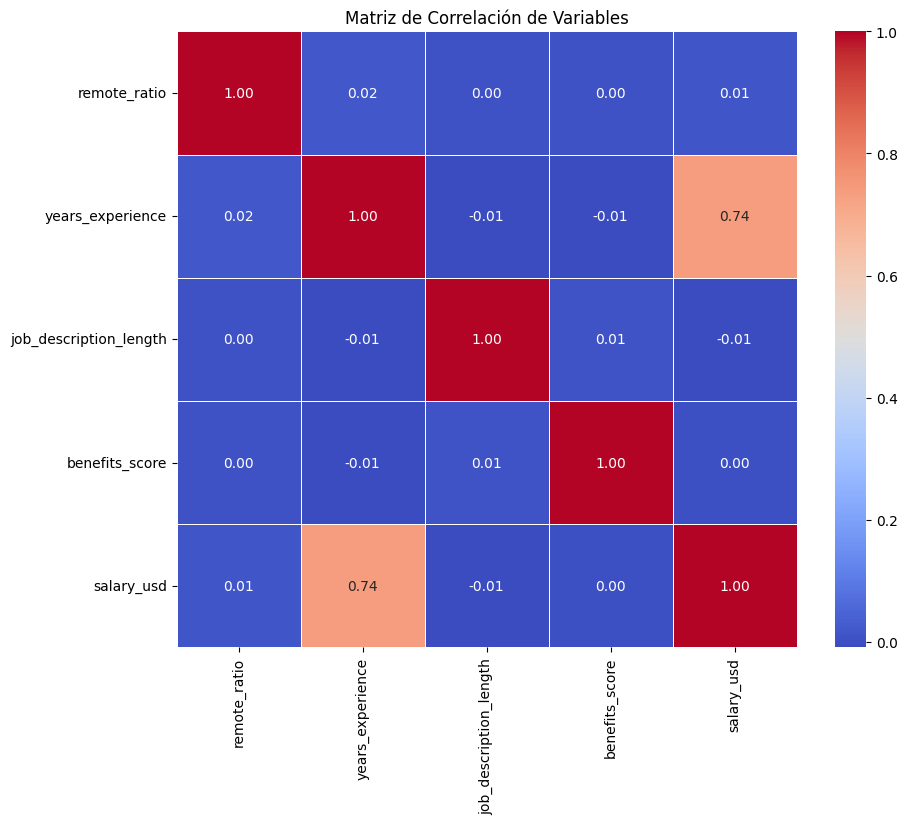


Correlaciones con la variable 'salary_usd':
salary_usd                1.000000
years_experience          0.737556
remote_ratio              0.013727
benefits_score            0.000985
job_description_length   -0.009092
Name: salary_usd, dtype: float64


In [18]:
corr_features = numeric_features + ["salary_usd"] #Calculamos la matriz de correlación con los valores numéricos (features y target)

correlation_matrix = df[corr_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables')
plt.show()

print("\nCorrelaciones con la variable 'salary_usd':")
print(correlation_matrix["salary_usd"].sort_values(ascending=False))

In [19]:
# Como vemos arriba, la variable numérica con mayor correlación con el salario es la de años de experiencia.

#A continuación, avanzamos con el preprocesamiento, utilizando ColumnTransformer, OHE y StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['experience_level', 'employment_type',
                                  'company_size', 'education_required']),
                                ('num', StandardScaler(),
                                 ['remote_ratio', 'years_experience',
                                  'job_description_length',
                                  'benefits_score'])])

In [20]:
#Dividimos los datos para el entrenamiento y testeo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")
print(f"Tamaño del conjunto de entrenamiento (y_train): {y_train.shape}")
print(f"Tamaño del conjunto de prueba (y_test): {y_test.shape}")

Tamaño del conjunto de entrenamiento (X_train): (11250, 8)
Tamaño del conjunto de prueba (X_test): (3750, 8)
Tamaño del conjunto de entrenamiento (y_train): (11250,)
Tamaño del conjunto de prueba (y_test): (3750,)


# Construcción y Entrenamiento del modelo

In [26]:
#Creamos el Pipeline con el preprocesador y añadiendo el regresor (RandomForest)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=10))
    ])

In [27]:
#Entrenamos el pipeline completo

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'company_size',
                                                   'education_required']),
                                                 ('num', StandardScaler(),
                                                  ['remote_ratio',
                                                   'years_experience',
                                                   'job_description_length',
                                                   'benefits_score'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_split=10,
                                       n_estimators=500, n_jobs=-1,
                                       random_state=42))])

In [28]:
#Procedemos a evaluar el modelo mediante predicciones en el conjunto de prueba

y_pred = model_pipeline.predict(X_test)

In [29]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- Métricas de Evaluación del Modelo de Regresión ---")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

print("\nInterpretación:")
print(f"- MAE: En promedio, las predicciones del modelo se desvían en ${mae:,.2f} del valor real del salario.")
print(f"- RMSE: La desviación típica de los errores es de ${rmse:,.2f}.")
print(f"- R²: El {r2*100:.2f}% de la varianza en el valor mediano de los salarios puede ser explicada por las características del modelo.")

--- Métricas de Evaluación del Modelo de Regresión ---
Error Absoluto Medio (MAE): 28106.5223
Error Cuadrático Medio (MSE): 1434682036.6743
Coeficiente de Determinación (R²): 0.6157

Interpretación:
- MAE: En promedio, las predicciones del modelo se desvían en $28,106.52 del valor real del salario.
- RMSE: La desviación típica de los errores es de $37,877.20.
- R²: El 61.57% de la varianza en el valor mediano de los salarios puede ser explicada por las características del modelo.


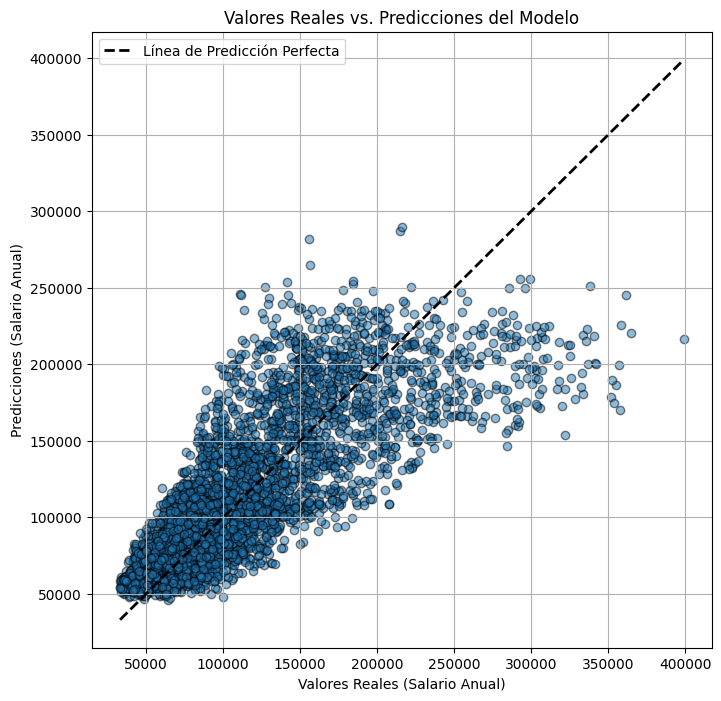

In [32]:
#Creamos un gráfico para ver cómo performaron las predicciones del modelo vs los valores reales

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Línea de Predicción Perfecta')
plt.xlabel('Valores Reales (Salario Anual)')
plt.ylabel('Predicciones (Salario Anual)')
plt.title('Valores Reales vs. Predicciones del Modelo')
plt.legend()
plt.grid(True)
plt.show()

# Conclusiones
##Validación de Hipótesis:

La Hipótesis Alternativa (H1) queda validada por el modelo, aunque lejos de ser perfecta para predecir valores (sobre todo los salarios superiores, alejados de la mediana) tiene un rendimiento lo suficientemente bueno para cumplir su función.

En cuanto a las hipótesis específicas, solo la HA1 es válida (Executive gana más que el resto de categorías), ya que la HA2 (mayor presencialidad, mayor salario) es descartada por una correlación prácticamente nula entre remote_ratio y salary_usd (0.013727), y la HA3 (países europeos pagan salarios mas altos que asiáticos) se rechaza al haber varias excepciones al enunciado.

Podríamos destacar la correlación positiva entre años de experiencia y salario, de 0.74, que indicaría que en promedio se pagan salarios mayores a medida que aumenten los años de experiencia.

In [35]:
print(f"Obtuvimos un R² de {r2:.2f} y un MAE de {mae:.2f}")

if r2 > 0.5: # Umbral de ejemplo para R²
    print("RESULTADO: La hipótesis alternativa (H1) es soportada por los resultados. El modelo explica una porción considerable de la varianza y es significativamente mejor que un modelo base.")
    print("Rechazamos la hipótesis nula (H0).")
else:
    print("RESULTADO: La hipótesis alternativa (H1) no es completamente soportada o el modelo tiene un rendimiento bajo (R² <= 0.5).")
    print("Se podría necesitar mejorar el modelo, realizar más ingeniería de características o considerar si las características actuales son suficientes.")

Obtuvimos un R² de 0.62 y un MAE de 28106.52 (que corresponde a $28,107).
RESULTADO: La hipótesis alternativa (H1) es soportada por los resultados. El modelo explica una porción considerable de la varianza y es significativamente mejor que un modelo base.
Rechazamos la hipótesis nula (H0).


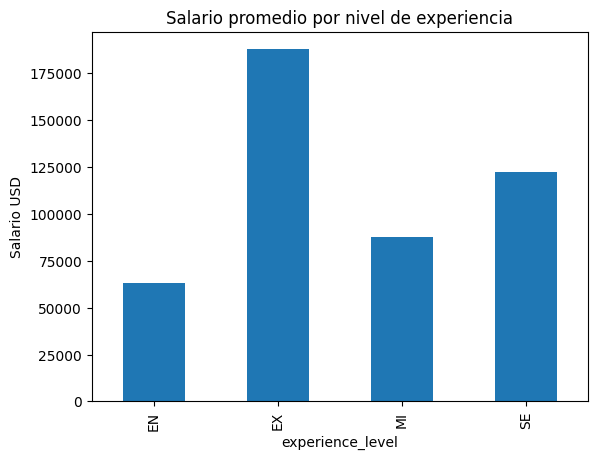

In [31]:
#Acá comprobamos la HA1, en donde vemos que Executive y Senior tienen salarios promedios mayores al resto de niveles.

df.groupby("experience_level")["salary_usd"].mean().plot(kind="bar")
plt.title("Salario promedio por nivel de experiencia")
plt.ylabel("Salario USD")
plt.show()

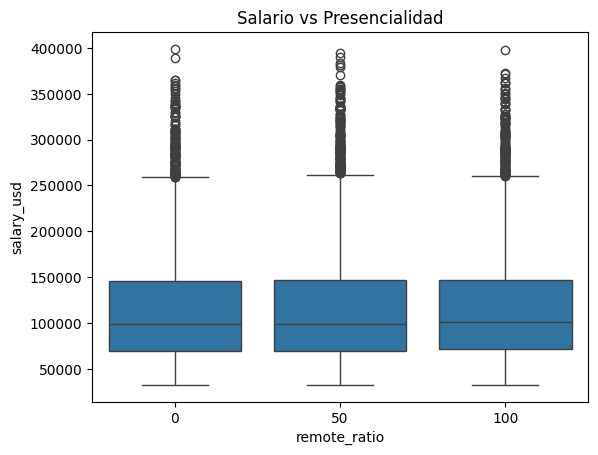

In [36]:
#Descartamos la HA2 por su correlación nula explicada más arriba,
#y vemos mediante un boxplot que son prácticamente iguales (con la presencia de varios outliers)

sns.boxplot(x="remote_ratio", y="salary_usd", data=df)
plt.title("Salario vs Presencialidad")
plt.show()

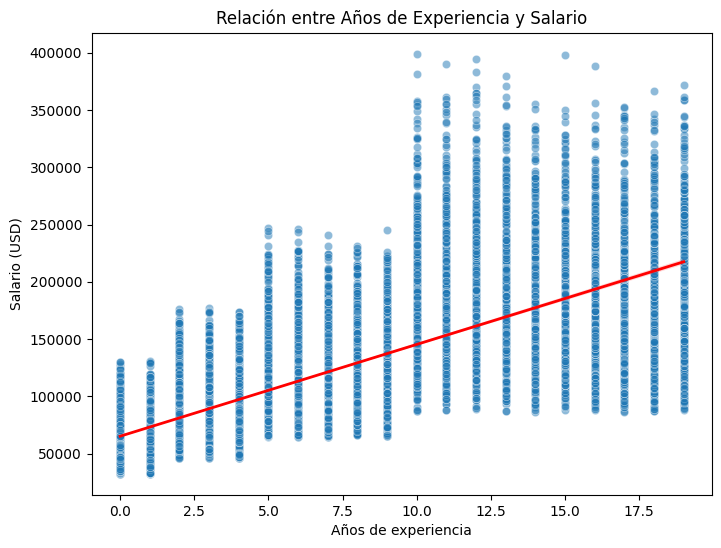

In [39]:
#Para terminar, el hallazgo de los años de experiencia vs salario.

plt.figure(figsize=(8,6))
sns.scatterplot(x="years_experience", y="salary_usd", data=df, alpha=0.5)
sns.regplot(x="years_experience", y="salary_usd", data=df,
            scatter=False, color="red", line_kws={"lw":2})
plt.title("Relación entre Años de Experiencia y Salario")
plt.xlabel("Años de experiencia")
plt.ylabel("Salario (USD)")
plt.show()


## ¡Muchas gracias!